# Project Title: Financial Market Data Analysis Toolkit Part 5 - ML Directional Forecasting

**Author:** Siddhant Dhoot

[LinkedIn](https://www.linkedin.com/in/siddhant-dhoot/)

**Date:** June 28, 2025

**Description:** A Python script that frames market prediction as a binary classification problem ("up" or "down"). It uses historical market data to engineer features and trains a supervised machine learning model to predict the next day's market direction.

**Purpose:** To practice the end-to-end machine learning pipeline. This includes hypothesis generation, creative feature engineering, model training (e.g., Logistic Regression or a simple Neural Network), and evaluating model performance using metrics like accuracy on unseen data.

<h4>Step 1: Import Python Libraries</h4>

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
from keras import layers
from keras import ops
from keras.callbacks import EarlyStopping
import datetime
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.utils import class_weight
from xgboost import XGBClassifier

%matplotlib inline

<h4>Step 2: Get user input for ticker</h4>

In [2]:
ticker = input("Enter the ticker: ")
start_date = input("Start date for historical analysis (YYYY-MM-DD): ")
end_date = input("End date for historical analysis (YYYY-MM-DD): ")

Enter the ticker:  ^GSPC
Start date for historical analysis (YYYY-MM-DD):  1980-01-01
End date for historical analysis (YYYY-MM-DD):  2025-01-01


<h4>Step 3: Create a datetime object to adjust start date by 20 and end day by 1 for accurate calculations</h4>

In [3]:
format_date = "%Y-%m-%d"
#Create datetime object
start_date = datetime.datetime.strptime(start_date,format_date) 
end_date = datetime.datetime.strptime(end_date,format_date) 
#Define the period you want to go back/ahead
preceding_period = datetime.timedelta(days = 20)
future_period = datetime.timedelta(days = 1)
#Move the start date back/end data forward
start_date_new = start_date - preceding_period
end_date_new = end_date + future_period
#Convert the datetime object back to string
start_date_new = start_date_new.strftime(format_date)
start_date = start_date.strftime(format_date) 
end_date = end_date.strftime(format_date) 

<h4>Step 4: Create a yfinance object and import closing price data for all tickers. Initialize an empty DataFrame to store all values together</h4>

In [4]:
#Create the DataFrame objects 
stock_data = pd.DataFrame()
#Import historical data using .history() and creating a master DataFrame by adding additional columns with closing price for each stock
stock_object = yf.Ticker(ticker)
stock_historical = stock_object.history(start = start_date_new , end = end_date_new, interval ="1d")
stock_data = stock_data.assign(**{ticker: stock_historical['Close']})
stock_data.reset_index(inplace=True)
stock_data

,Date,^GSPC
0,1979-12-12 00:00:00-05:00,107.519997
1,1979-12-13 00:00:00-05:00,107.669998
2,1979-12-14 00:00:00-05:00,108.919998
3,1979-12-17 00:00:00-05:00,109.330002
4,1979-12-18 00:00:00-05:00,108.300003
...,...,...
11353,2024-12-24 00:00:00-05:00,6040.040039
11354,2024-12-26 00:00:00-05:00,6037.589844
11355,2024-12-27 00:00:00-05:00,5970.839844
11356,2024-12-30 00:00:00-05:00,5906.939941


<h4>Step 5: Feature Engineering - Part 1 - Frame a classification problem to enable supervised learning</h4>

In [5]:
# First create the Direction column with empty strings
stock_data["Direction"] = ''

#If the market closing for the next day is higher than today's, direction = 1 else direction = 0
for i in range(len(stock_data)-1):
    if stock_data[ticker][i] < stock_data[ticker][i+1]:
        stock_data.loc[i, "Direction"] = 1
    else:
        stock_data.loc[i, "Direction"] = 0
stock_data

,Date,^GSPC,Direction
0,1979-12-12 00:00:00-05:00,107.519997,1
1,1979-12-13 00:00:00-05:00,107.669998,1
2,1979-12-14 00:00:00-05:00,108.919998,1
3,1979-12-17 00:00:00-05:00,109.330002,0
4,1979-12-18 00:00:00-05:00,108.300003,0
...,...,...,...
11353,2024-12-24 00:00:00-05:00,6040.040039,0
11354,2024-12-26 00:00:00-05:00,6037.589844,0
11355,2024-12-27 00:00:00-05:00,5970.839844,0
11356,2024-12-30 00:00:00-05:00,5906.939941,0


<h4>Step 6: Feature Engineering - Part 2 - Creating Returns related features</h4>

In [6]:
#Create new empty columns for 1-5d return and calculate using .pct_change()
#This will help the model look the ticker's recent momentum
stock_data["1d-returns"]= stock_data[ticker].pct_change()
stock_data["2d-returns"] = stock_data[ticker].pct_change(periods = 2)  
stock_data["3d-returns"] = stock_data[ticker].pct_change(periods = 3)
stock_data["4d-returns"] = stock_data[ticker].pct_change(periods = 4)
stock_data["5d-returns"] = stock_data[ticker].pct_change(periods = 5)

#Create new empty columns for 1-5d lagged returns and populate using .shift()
#This will tell the model about daily returns from upto 5 days ago
stock_data["1d-lagged-returns"]= stock_data["1d-returns"].shift(1)
stock_data["2d-lagged-returns"]= stock_data["1d-returns"].shift(2)
stock_data["3d-lagged-returns"]= stock_data["1d-returns"].shift(3)
stock_data["4d-lagged-returns"]= stock_data["1d-returns"].shift(4)
stock_data["5d-lagged-returns"]= stock_data["1d-returns"].shift(5)

stock_data

,Date,^GSPC,Direction,1d-returns,2d-returns,3d-returns,4d-returns,5d-returns,1d-lagged-returns,2d-lagged-returns,3d-lagged-returns,4d-lagged-returns,5d-lagged-returns
0,1979-12-12 00:00:00-05:00,107.519997,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1979-12-13 00:00:00-05:00,107.669998,1,0.001395,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1979-12-14 00:00:00-05:00,108.919998,1,0.011610,0.013021,NaN,NaN,NaN,0.001395,NaN,NaN,NaN,NaN
3,1979-12-17 00:00:00-05:00,109.330002,0,0.003764,0.015418,0.016834,NaN,NaN,0.011610,0.001395,NaN,NaN,NaN
4,1979-12-18 00:00:00-05:00,108.300003,0,-0.009421,-0.005692,0.005851,0.007255,NaN,0.003764,0.011610,0.001395,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
11353,2024-12-24 00:00:00-05:00,6040.040039,0,0.011043,0.018411,0.029480,0.028589,-0.001747,0.007287,0.010869,-0.000865,-0.029493,-0.003864
11354,2024-12-26 00:00:00-05:00,6037.589844,0,-0.000406,0.010633,0.017997,0.029062,0.028172,0.011043,0.007287,0.010869,-0.000865,-0.029493
11355,2024-12-27 00:00:00-05:00,5970.839844,0,-0.011056,-0.011457,-0.000541,0.006743,0.017685,-0.000406,0.011043,0.007287,0.010869,-0.000865
11356,2024-12-30 00:00:00-05:00,5906.939941,0,-0.010702,-0.021639,-0.022036,-0.011237,-0.004031,-0.011056,-0.000406,0.011043,0.007287,0.010869


<h4>Step 7: Feature Engineering - Part 3 - Creating Volatility related features</h4>

In [7]:
#Create two new empty columns for 5d and 20d std-dev as a proxy for short- and medium-term volatility
stock_data["5d-std-dev"] = stock_data["1d-returns"].rolling(5).std()  
stock_data["20d-std-dev"] = stock_data["1d-returns"].rolling(20).std()
stock_data

,Date,^GSPC,Direction,1d-returns,2d-returns,3d-returns,4d-returns,5d-returns,1d-lagged-returns,2d-lagged-returns,3d-lagged-returns,4d-lagged-returns,5d-lagged-returns,5d-std-dev,20d-std-dev
0,1979-12-12 00:00:00-05:00,107.519997,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1979-12-13 00:00:00-05:00,107.669998,1,0.001395,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1979-12-14 00:00:00-05:00,108.919998,1,0.011610,0.013021,NaN,NaN,NaN,0.001395,NaN,NaN,NaN,NaN,NaN,NaN
3,1979-12-17 00:00:00-05:00,109.330002,0,0.003764,0.015418,0.016834,NaN,NaN,0.011610,0.001395,NaN,NaN,NaN,NaN,NaN
4,1979-12-18 00:00:00-05:00,108.300003,0,-0.009421,-0.005692,0.005851,0.007255,NaN,0.003764,0.011610,0.001395,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11353,2024-12-24 00:00:00-05:00,6040.040039,0,0.011043,0.018411,0.029480,0.028589,-0.001747,0.007287,0.010869,-0.000865,-0.029493,-0.003864,0.017055,0.008773
11354,2024-12-26 00:00:00-05:00,6037.589844,0,-0.000406,0.010633,0.017997,0.029062,0.028172,0.011043,0.007287,0.010869,-0.000865,-0.029493,0.005876,0.008687
11355,2024-12-27 00:00:00-05:00,5970.839844,0,-0.011056,-0.011457,-0.000541,0.006743,0.017685,-0.000406,0.011043,0.007287,0.010869,-0.000865,0.009390,0.009007
11356,2024-12-30 00:00:00-05:00,5906.939941,0,-0.010702,-0.021639,-0.022036,-0.011237,-0.004031,-0.011056,-0.000406,0.011043,0.007287,0.010869,0.010112,0.009190


<h4>Step 8: Feature Engineering - Part 4 - Creating Return X Volatility crossed features and Date related functions</h4>

In [8]:
#Create two new empty columns for short- and medium-term Volatility adjusted daily returns (feature crosses)
#This will help the model learn the non-linear relationships between returns and volatility that would otherwise be difficult to learn
stock_data["1d-returns-5d-volatility-cross"]= stock_data["1d-returns"] * stock_data["5d-std-dev"]
stock_data["1d-returns-20d-volatility-cross"]= stock_data["1d-returns"] * stock_data["20d-std-dev"]

stock_data['day_of_week'] = stock_data['Date'].dt.dayofweek # Monday=0, Sunday=6
stock_data['month'] = stock_data['Date'].dt.month

stock_data

,Date,^GSPC,Direction,1d-returns,2d-returns,3d-returns,4d-returns,5d-returns,1d-lagged-returns,2d-lagged-returns,3d-lagged-returns,4d-lagged-returns,5d-lagged-returns,5d-std-dev,20d-std-dev,1d-returns-5d-volatility-cross,1d-returns-20d-volatility-cross,day_of_week,month
0,1979-12-12 00:00:00-05:00,107.519997,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,12
1,1979-12-13 00:00:00-05:00,107.669998,1,0.001395,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,12
2,1979-12-14 00:00:00-05:00,108.919998,1,0.011610,0.013021,NaN,NaN,NaN,0.001395,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,12
3,1979-12-17 00:00:00-05:00,109.330002,0,0.003764,0.015418,0.016834,NaN,NaN,0.011610,0.001395,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,12
4,1979-12-18 00:00:00-05:00,108.300003,0,-0.009421,-0.005692,0.005851,0.007255,NaN,0.003764,0.011610,0.001395,NaN,NaN,NaN,NaN,NaN,NaN,1,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11353,2024-12-24 00:00:00-05:00,6040.040039,0,0.011043,0.018411,0.029480,0.028589,-0.001747,0.007287,0.010869,-0.000865,-0.029493,-0.003864,0.017055,0.008773,0.000188,0.000097,1,12
11354,2024-12-26 00:00:00-05:00,6037.589844,0,-0.000406,0.010633,0.017997,0.029062,0.028172,0.011043,0.007287,0.010869,-0.000865,-0.029493,0.005876,0.008687,-0.000002,-0.000004,3,12
11355,2024-12-27 00:00:00-05:00,5970.839844,0,-0.011056,-0.011457,-0.000541,0.006743,0.017685,-0.000406,0.011043,0.007287,0.010869,-0.000865,0.009390,0.009007,-0.000104,-0.000100,4,12
11356,2024-12-30 00:00:00-05:00,5906.939941,0,-0.010702,-0.021639,-0.022036,-0.011237,-0.004031,-0.011056,-0.000406,0.011043,0.007287,0.010869,0.010112,0.009190,-0.000108,-0.000098,0,12


<h4>Step 9: Clean the dataset</h4>

In [9]:
#Get rid of all rows added just for calculations
start_idx = stock_data.index[stock_data['Date'] >= start_date].min()
end_idx = stock_data.index[stock_data['Date'] <= end_date].max()
stock_data = stock_data.iloc[start_idx-1:end_idx]

#Raw Dates were just for our understanding, the model does not interpret those as Dates and will be misled due to it
stock_data.pop("Date")
stock_data.dropna(inplace=True)

stock_data

C:\Users\siddh\AppData\Local\Temp\ipykernel_12052\2739136442.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_data.dropna(inplace=True)


,^GSPC,Direction,1d-returns,2d-returns,3d-returns,4d-returns,5d-returns,1d-lagged-returns,2d-lagged-returns,3d-lagged-returns,4d-lagged-returns,5d-lagged-returns,5d-std-dev,20d-std-dev,1d-returns-5d-volatility-cross,1d-returns-20d-volatility-cross,day_of_week,month
20,109.919998,1,0.000273,0.007978,0.008903,0.029117,0.031919,0.007703,0.000918,0.020036,0.002723,0.012355,0.008196,0.008321,0.000002,0.000002,4,1
21,110.379997,1,0.004185,0.004459,0.012196,0.013125,0.033424,0.000273,0.007703,0.000918,0.020036,0.002723,0.008060,0.008349,0.000034,0.000035,0,1
22,111.139999,0,0.006885,0.011099,0.011375,0.019165,0.020101,0.004185,0.000273,0.007703,0.000918,0.020036,0.003371,0.008104,0.000023,0.000056,1,1
23,111.050003,0,-0.000810,0.006070,0.010280,0.010556,0.018340,0.006885,0.004185,0.000273,0.007703,0.000918,0.003823,0.008088,-0.000003,-0.000007,2,1
24,110.699997,1,-0.003152,-0.003959,0.002899,0.007096,0.007371,-0.000810,0.006885,0.004185,0.000273,0.007703,0.004021,0.007786,-0.000013,-0.000025,3,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11352,5974.069824,1,0.007287,0.018236,0.017355,-0.012650,-0.016465,0.010869,-0.000865,-0.029493,-0.003864,0.003799,0.015852,0.008441,0.000116,0.000062,0,12
11353,6040.040039,0,0.011043,0.018411,0.029480,0.028589,-0.001747,0.007287,0.010869,-0.000865,-0.029493,-0.003864,0.017055,0.008773,0.000188,0.000097,1,12
11354,6037.589844,0,-0.000406,0.010633,0.017997,0.029062,0.028172,0.011043,0.007287,0.010869,-0.000865,-0.029493,0.005876,0.008687,-0.000002,-0.000004,3,12
11355,5970.839844,0,-0.011056,-0.011457,-0.000541,0.006743,0.017685,-0.000406,0.011043,0.007287,0.010869,-0.000865,0.009390,0.009007,-0.000104,-0.000100,4,12


<h4>Step 10: Split the dataset into training and test sets</h4>

In [10]:
#Isolate the target variable
feature_cols = ["1d-returns","2d-returns","3d-returns","4d-returns","5d-returns","1d-lagged-returns", "2d-lagged-returns", "3d-lagged-returns","4d-lagged-returns","5d-lagged-returns","5d-std-dev","20d-std-dev","1d-returns-5d-volatility-cross","1d-returns-20d-volatility-cross","day_of_week","month"]
#Remember to set shuffle to False, the data must be in the same order for our purposes. This is a time-series dataset.
x_train, x_test, y_train, y_test = train_test_split(stock_data[feature_cols], stock_data['Direction'], test_size = 0.2, shuffle=False)

# Initialize the scaler
scaler = StandardScaler()

# Fit the scaler ONLY on the training data
x_train_scaled = scaler.fit_transform(x_train)

# Transform the test data using the SAME fitted scaler
x_test_scaled = scaler.transform(x_test)

# Calculate the class weights from your training data
# This will automatically give the minority class a higher weight
weights = class_weight.compute_class_weight('balanced',
                                            classes=np.unique(y_train),
                                            y=y_train)
class_weight_dict = dict(enumerate(weights))

<h4>Step 11: Fit a basic Logistic Regression Model to get a baseline</h4>

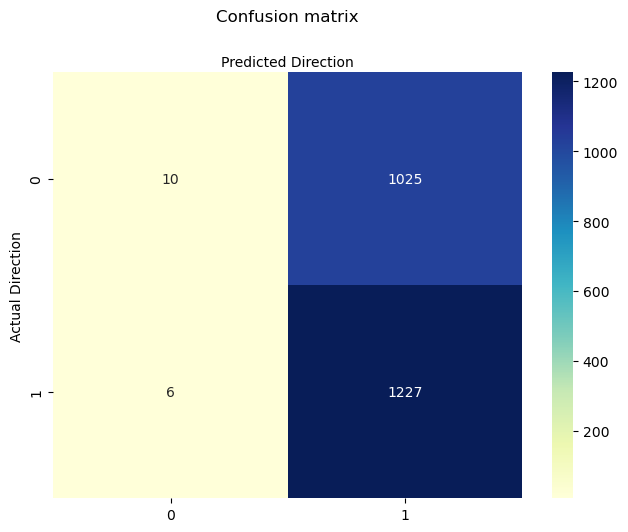

Accuracy = 0.5454144620811288
Precision = 0.5448490230905861
Recall = 0.9951338199513382
F1 Score = 0.7041606886657101


In [11]:
logreg = LogisticRegression(random_state = 42)
y_train = y_train.astype(int)
baseline_model = logreg.fit(x_train, y_train.values.ravel())
y_pred = baseline_model.predict(x_test)
y_test = y_test.astype(int)
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)

class_names=[0,1]
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual Direction')
plt.xlabel('Predicted Direction')
plt.show()

accuracy = metrics.accuracy_score(y_test, y_pred)
precision = metrics.precision_score(y_test, y_pred)
recall = metrics.recall_score(y_test, y_pred)
f1 = metrics.f1_score(y_test, y_pred)

print(f'Accuracy = {accuracy}')
print(f'Precision = {precision}')
print(f'Recall = {recall}')
print(f'F1 Score = {f1}')

<h4>Step 12: Define a Keras DNN</h4>

In [12]:
#Since we have 16 feature columns, we must tell Keras to expect a 16-dimensional vector while defining the model

# Model with Dropout
model = tf.keras.Sequential([
    tf.keras.layers.Dense(32, activation='relu', input_shape=(16,)),
    tf.keras.layers.Dropout(0.5), # Dropout layer: randomly drops 50% of neurons
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

# Compile the model
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Display the model's architecture
model.summary()

C:\Users\siddh\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 32)                  │             544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,089 (4.25 KB)

 Trainable params: 1,089 (4.25 KB)

 Non-trainable params: 0 (0.00 B)

<h4>Step 13: Fit the model and evaluate its performance</h4>

Epoch 1/100
227/227 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.4701 - loss: 0.8502 - val_accuracy: 0.4961 - val_loss: 0.7394
Epoch 2/100
227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4903 - loss: 0.7943 - val_accuracy: 0.5017 - val_loss: 0.7194
Epoch 3/100
227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4923 - loss: 0.7723 - val_accuracy: 0.5099 - val_loss: 0.7094
Epoch 4/100
227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.4959 - loss: 0.7572 - val_accuracy: 0.5176 - val_loss: 0.7038
Epoch 5/100
227/227 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.4891 - loss: 0.7516 - val_accuracy: 0.5121 - val_loss: 0.7000
Epoch 6/100
227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5062 - loss: 0.7465 - val_accuracy: 0.5061 - val_loss: 0.6978
Epoch 7/100
227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.4966 - loss: 0.7459 - val_accuracy: 0.5066 - val_loss: 0.6962
Epoch 8/100
227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4974 - loss: 0.7209 - val_accu

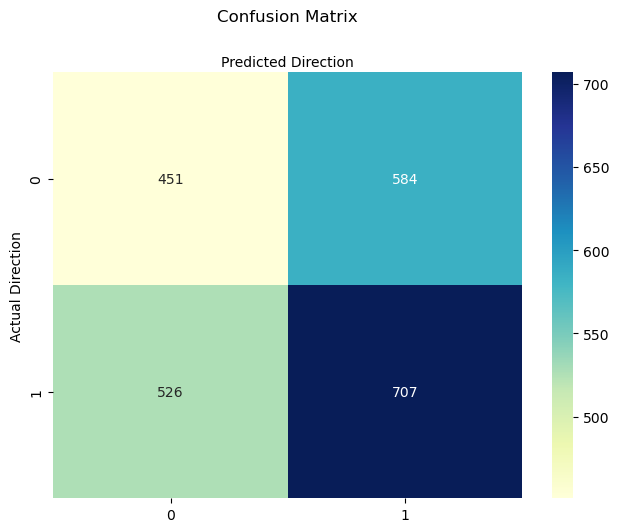

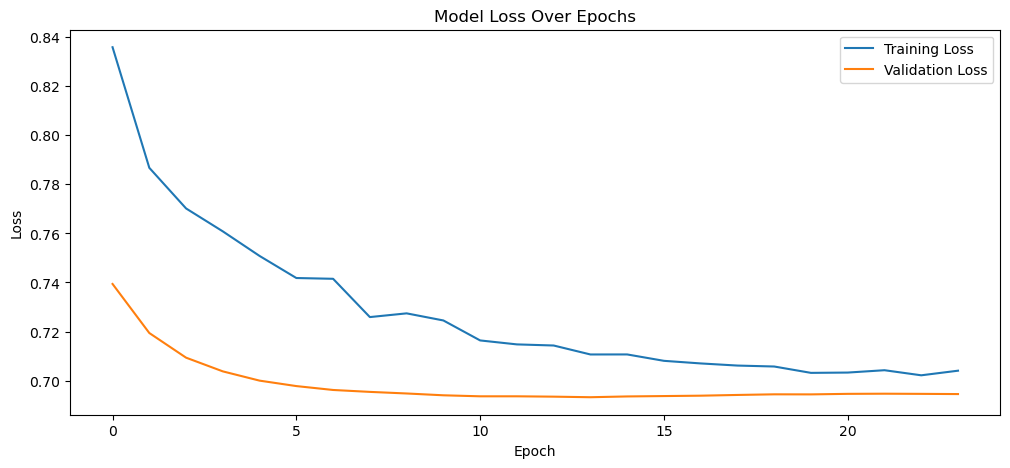

In [13]:
# Define the callback
early_stopping = EarlyStopping(monitor='val_loss', # Monitor validation loss
                               patience=10,        # Stop after 10 epochs with no improvement
                               restore_best_weights=True) # Restore the best model found

history = model.fit(x_train_scaled, y_train,
                    epochs=100, # Can set a high number, early stopping will handle it
                    batch_size=32,
                    class_weight=class_weight_dict,
                    validation_split=0.2,
                    callbacks=[early_stopping]) 

# Make predictions on the test set (outputs probabilities)
y_pred_probs = model.predict(x_test_scaled)

# Convert probabilities to binary classes (0 or 1) using a 0.5 threshold
y_pred_classes = (y_pred_probs > 0.5).astype("int32")

# Calculate metrics
accuracy = metrics.accuracy_score(y_test, y_pred_classes)
precision = metrics.precision_score(y_test, y_pred_classes)
recall = metrics.recall_score(y_test, y_pred_classes)
f1 = metrics.f1_score(y_test, y_pred_classes)

print(f'Accuracy = {accuracy}')
print(f'Precision = {precision}')
print(f'Recall = {recall}')
print(f'F1 Score = {f1}')

# Create and display the confusion matrix
cnf_matrix = metrics.confusion_matrix(y_test, y_pred_classes)
class_names=[0,1] # name of classes

fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion Matrix', y=1.1)
plt.ylabel('Actual Direction')
plt.xlabel('Predicted Direction')
plt.show()

# Plotting the training and validation loss
plt.figure(figsize=(12, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

<h4>Step 14: Try a different ML Model</h4>

XGBoost Accuracy = 0.513668430335097
XGBoost Precision = 0.5520833333333334
XGBoost Recall = 0.5587996755879967
XGBoost F1 Score = 0.5554212011285772


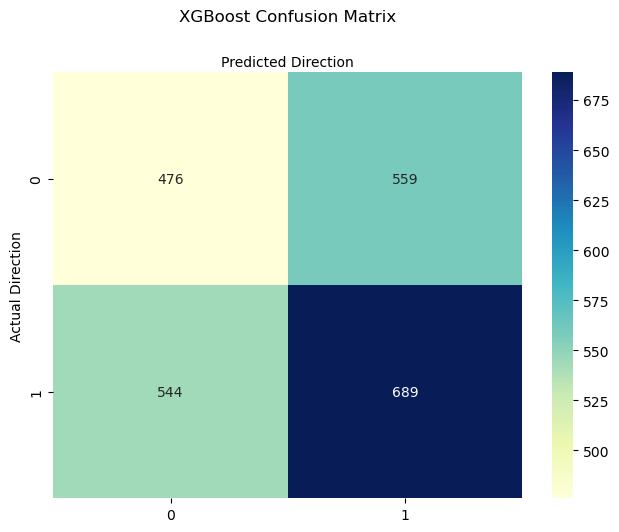

In [14]:
# Initialize and train the XGBoost model
xgb_model = XGBClassifier(random_state=42)
xgb_model.fit(x_train, y_train) # Note: For XGBoost, it's often better to use unscaled data

# Make predictions and evaluate
y_pred_xgb = xgb_model.predict(x_test)

# Calculate metrics
accuracy = metrics.accuracy_score(y_test, y_pred_xgb)
precision = metrics.precision_score(y_test, y_pred_xgb)
recall = metrics.recall_score(y_test, y_pred_xgb)
f1 = metrics.f1_score(y_test, y_pred_xgb)

print(f'XGBoost Accuracy = {accuracy}')
print(f'XGBoost Precision = {precision}')
print(f'XGBoost Recall = {recall}')
print(f'XGBoost F1 Score = {f1}')

# --- Step 3: Visualize the Confusion Matrix ---
cnf_matrix_xgb = metrics.confusion_matrix(y_test, y_pred_xgb)
class_names=[0,1]

fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)

sns.heatmap(pd.DataFrame(cnf_matrix_xgb), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('XGBoost Confusion Matrix', y=1.1)
plt.ylabel('Actual Direction')
plt.xlabel('Predicted Direction')
plt.show()

Final Analysis and Interpretation

This project set out to predict the next-day direction of the S&P 500 index (^GSPC) by framing it as a binary classification problem. A comprehensive set of features was engineered, including momentum indicators, lagged returns, volatility measures, and feature crosses. Three different models were trained and evaluated on a hold-out test set:

Baseline Model: Logistic Regression

Advanced Model 1: Keras Deep Neural Network (DNN) with regularization (Dropout) and tuning (scaling, class weights, early stopping).

Advanced Model 2: XGBoost Classifier (Gradient Boosting).

Performance Summary
The performance of each model on the unseen test data is summarized below:

| Metric | Logistic Regression (Baseline) | Keras DNN (Tuned) | XGBoost (Gradient Boosting) |
| :--- | :--- | :--- | :--- |
| **Accuracy** | **~54.5%** | ~51.1% | ~51.4% |
| **Precision**| ~54.5% | **~55.2%** | **~55.2%** |
| **Recall** | **~99.5%** | ~57.3% | ~55.9% |
| **F1 Score** | **~70.4%** | ~56.0% | ~55.5% |

Interpretation of Results

The final results are highly instructive and align with the challenges commonly faced in quantitative financial modeling.

The Baseline Prevails: The simplest model, Logistic Regression, achieved the highest overall Accuracy and F1 Score. Its strategy was heavily biased, essentially learning the market's slight historical upward drift and predicting "up" most of the time. This resulted in an extremely high Recall (it caught almost every true "up" day) but mediocre Precision. While not a sophisticated strategy, its F1 score sets a surprisingly high benchmark.

Complexity vs. Performance: The more complex, non-linear models (Keras DNN and XGBoost) did not outperform the simple baseline. They achieved slightly better Precision, indicating they were less prone to incorrectly guessing "up". However, their more balanced approach (lower Recall) resulted in lower overall F1 scores. This demonstrates that more model complexity does not guarantee better performance, especially on noisy data like financial returns.

The "Efficient Market" Hypothesis in Practice: This outcome is a powerful demonstration of the difficulty of predicting an efficient and liquid market index. The results strongly suggest that using only historical price and volatility data (i.e., technical analysis) provides a very faint, noisy signal for next-day direction. The inability of even advanced models to find a consistent predictive edge is not a failure of the methodology but rather a reflection of the problem's inherent difficulty.

Project Conclusion
This project successfully demonstrates a complete, end-to-end machine learning workflow. It covers the entire process from problem framing and creative feature engineering to implementing and tuning multiple classes of models.

The final result is not a highly profitable trading model, but a valuable analytical insight: predicting the S&P 500's direction is a non-trivial problem. 